# 统计学习导论第十七次作业
作业任务1：stacking  
作业任务2：voting  
跳过数据预处理部分，可以点这[跳过预处理](#1)  
Ensemble Learning全部算法对比，由于我这三次作业用的一个数据集，可以点这[对比所有模型拟合效果](#2)  

姓名：欧阳瑞志、班级：统计22、学号：220403102

## 一、业务理解
##### 数据来源
阿里天池提供的【Banking Dataset Classification银行数据集分类】    
##### 数据种类
分类数据，分类标签：客户是否已订阅定期存款    
##### 数据网站
https://tianchi.aliyun.com/dataset/92775  
##### 数据内容
银行定期存款营销——采用更为【激进】的策略  
##### 数据类型：  
###### 15个特征：
1、age年龄 连续数据
2、job工作 分类数据
3、marital婚姻 分类数据
4、education教育情况 分类数据
5、default为履行的债务 分类数据
6、housing住房 分类数据
7、loan贷款 分类数据
8、contact联系类型 分类数据
9、month一年中的最后一个联系月份 分类数据
10、day_of_week一周中的最后一个联系日 分类数据
11、duration上一次联系时间 连续数据
12、campaign活动 连续数据
13、pdays天数 连续数据
14、previous之前联系的数量 连续数据
15、poutcome之前的结果 分类数据
###### 1个标签：
1、y客户是否已订阅定期存款 分类数据（是与否）

In [2]:
#--------------------------------1、业务理解--------------------------------#
import pandas as pd
import warnings
warnings.filterwarnings("ignore") 

## 数据导入
# 阿里天池提供的【Banking Dataset Classification银行数据集分类】
# 分类数据，分类标签：客户是否已订阅定期存款
# https://tianchi.aliyun.com/dataset/92775
data_train = pd.read_csv("/Users/ouyangruizhi/Desktop/python/统计学习导论/建模流程/new_train.csv")   # 用的绝对路径
data_test = pd.read_csv("/Users/ouyangruizhi/Desktop/python/统计学习导论/建模流程/new_test.csv")

# 展示前五行数据和数据形状
print('前五行数据：')
data_train.head()

前五行数据：


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no


## 二、数据探索
### 2.1 数据概览
由于输入和输出变量只有16个，可以绘制所有数据的可视化图  
其中对于数值型数据绘制直方图、对于分类数据绘制直条图

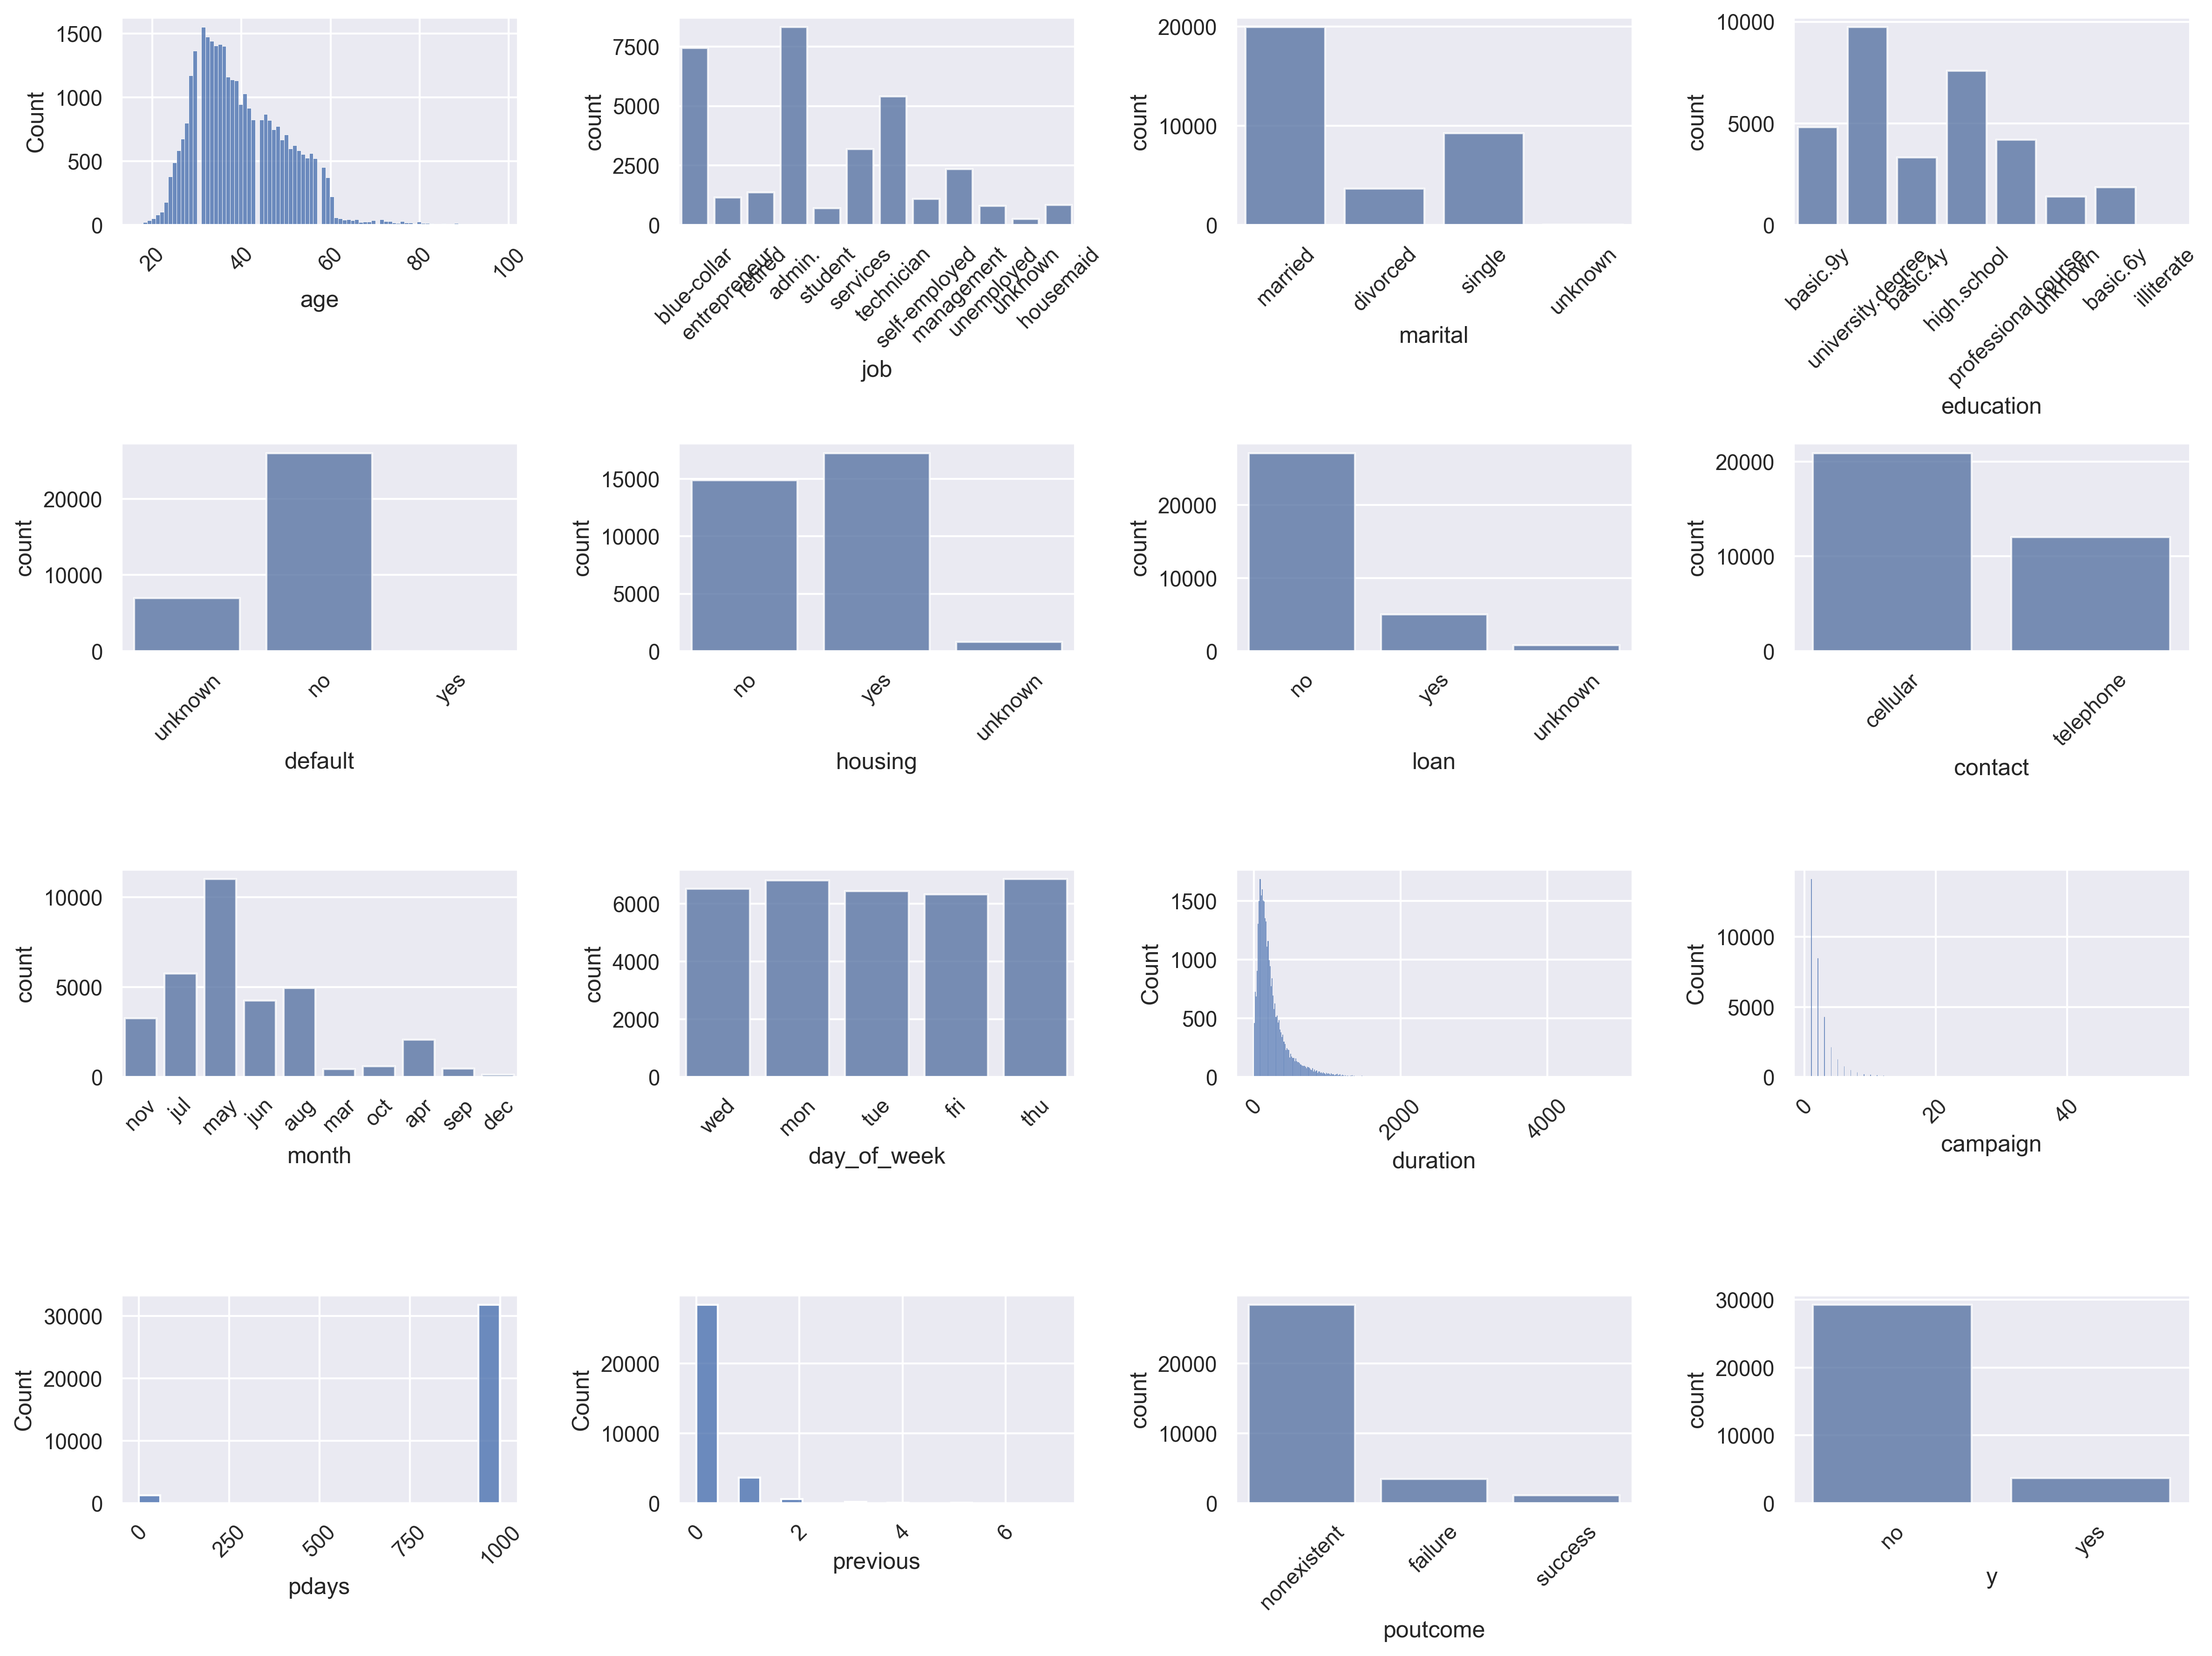

In [3]:
#--------------------------------2、数据探索--------------------------------#
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

## 绘制全部指标的概览
sns.set_theme(font_scale=1)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16, 12), dpi = 300)
axes = axes.flatten()

columns = ['age', 'job','marital', 'education', 'default', 'housing', 'loan', 'contact',
                   'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

# 循环绘制每个子图
for i, column in enumerate(columns):
    if column in ['age', 'duration', 'campaign', 'pdays', 'previous']:
        # 对于连续数据，使用histplot
        g = sns.histplot(data=data_train, x=column, color='b', alpha=0.8, ax=axes[i])
    else:
        # 对于分类数据，使用countplot
        g = sns.countplot(data=data_train, x=column, color='b', alpha=0.8, ax=axes[i])

    locator = axes[i].get_xticks()
    axes[i].xaxis.set_major_locator(plt.FixedLocator(locator))
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

for j in range(len(columns), 16):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(fname="数据概览.png")

### 2.2 重要单指标的密度函数
由于数值型数据只有5个，直接绘制所有数值型数据的密度函数

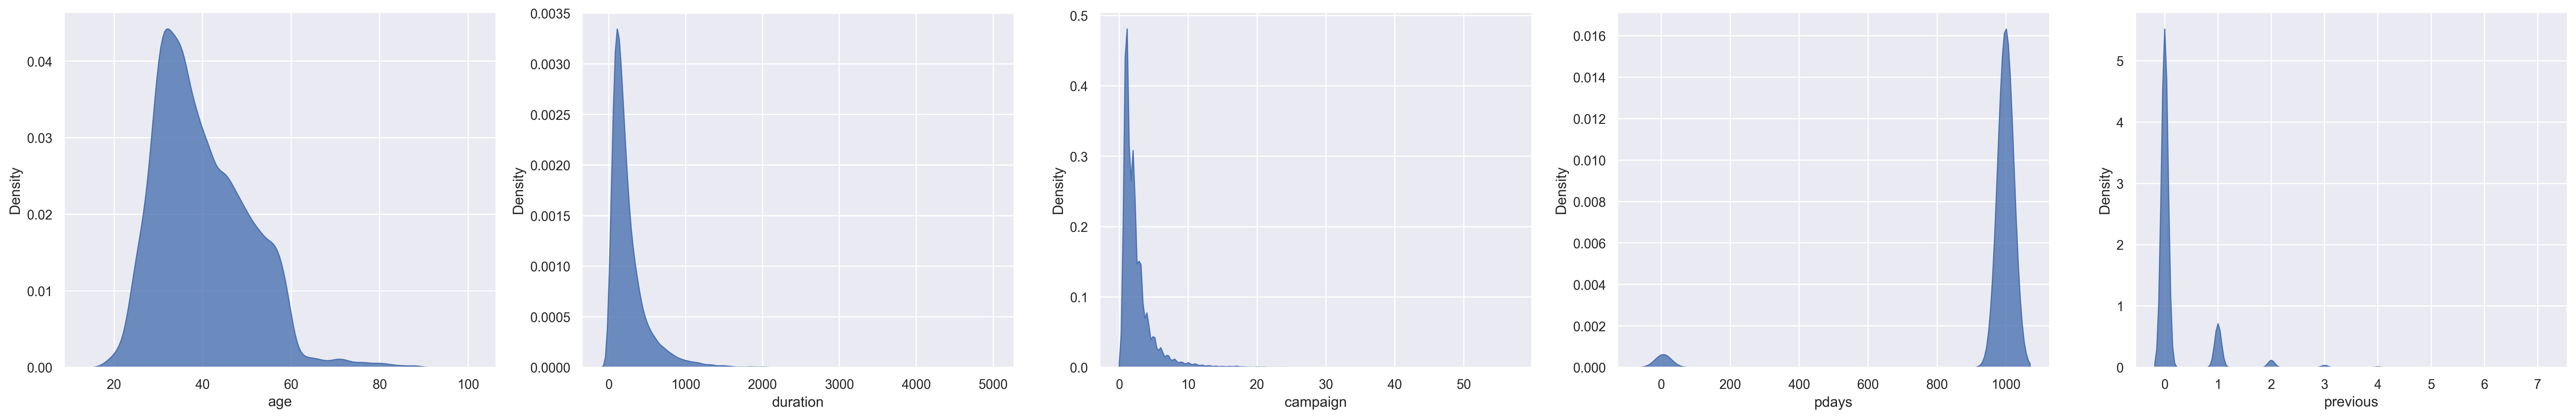

In [4]:
## 绘制重要单指标的密度函数
sns.set_theme(font_scale=1)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 5), dpi = 300)
axes = axes.flatten()

indicators = ['age', 'duration', 'campaign', 'pdays', 'previous']

for i, indicator in enumerate(indicators):
    g_age_density = sns.kdeplot(data=data_train, x=indicator, fill=True, color='b', alpha=0.8, ax=axes[i])
    axes[i].set_xlabel(indicators[i])
    axes[i].set_ylabel("Density")

for j in range(len(indicators), 5):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(fname="指标密度函数图.png")

### 2.3 Box-Cox变换
观察到数据没有符合正态分布的数据，使用Box-Cox变换，将非正态分布的数据转换为近似正态分布的数据。  
Box-Cox变换公式：
$$
y^{(\lambda)} = \left\{\begin{matrix} \frac{y^{\lambda}-1}{\lambda} &\lambda \neq 0 \\ ln(y) &\lambda = 0 \end{matrix}\right.
$$
变换需要满足：
$$
\frac{y_{max}}{y_{min}} > 2
$$
对age直接做强度稍为更大的对数变换、由于duration、campaign存在'0'所以退而求其次做强度稍为更小的平方根变换、pdays和previous存在多峰的情况因此不做变换

前五行数据：


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,y,ln_age,sqrt_duration,sqrt_campaign
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,999,0,nonexistent,no,3.891820,15.066519,2.000000
1,37,entrepreneur,married,university.degree,no,no,no,telephone,nov,wed,202,2,999,1,failure,no,3.610918,14.212670,1.414214
2,78,retired,married,basic.4y,no,no,no,cellular,jul,mon,1148,1,999,0,nonexistent,yes,4.356709,33.882149,1.000000
3,36,admin.,married,university.degree,no,yes,no,telephone,may,mon,120,2,999,0,nonexistent,no,3.583519,10.954451,1.414214
4,59,retired,divorced,university.degree,no,no,no,cellular,jun,tue,368,2,999,0,nonexistent,no,4.077537,19.183326,1.414214


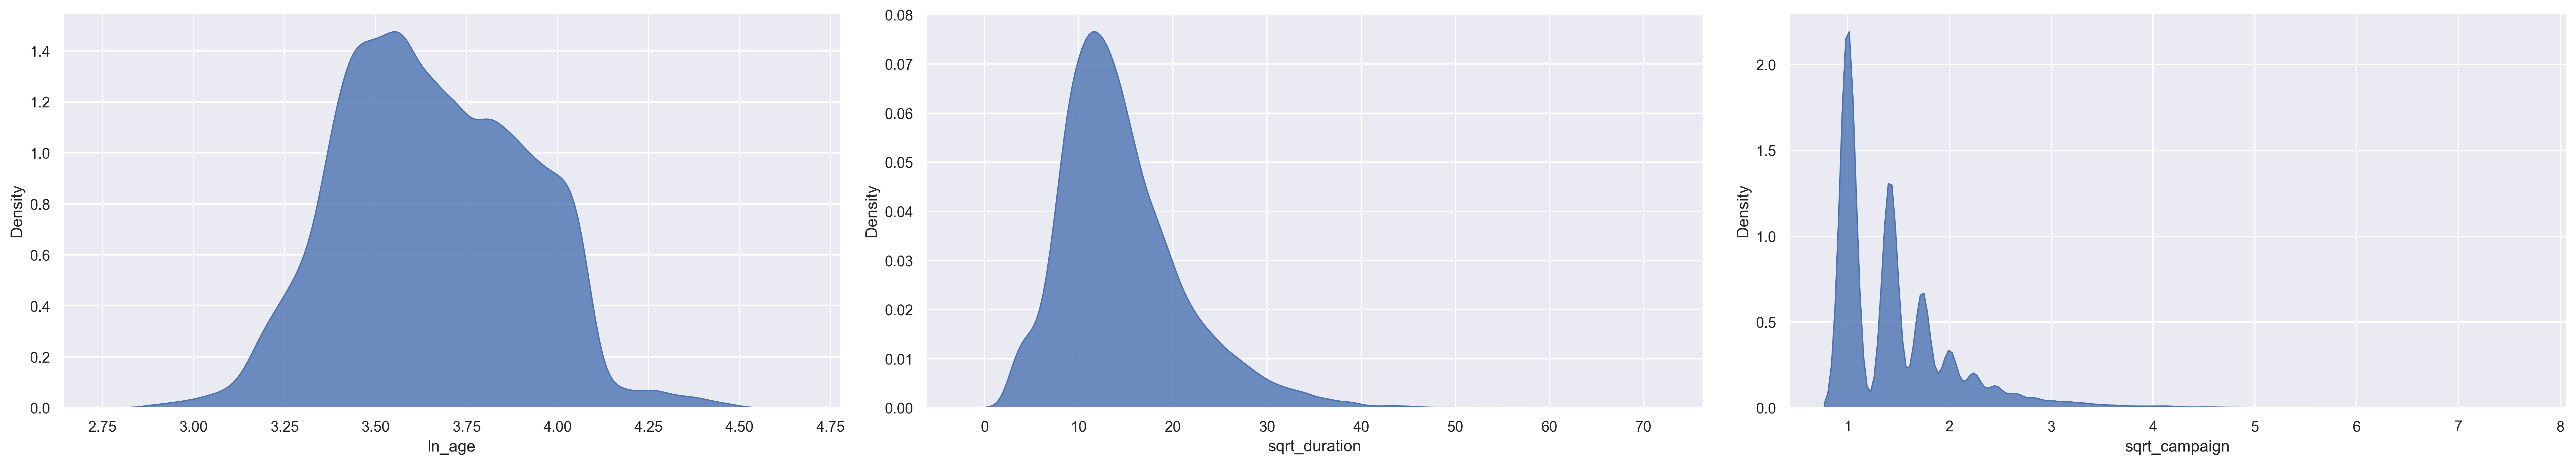

In [5]:
## BOX-COX变换
# 对age列进行对数变换
data_train['ln_age'] = np.log(data_train['age'])
data_train['sqrt_duration'] = np.sqrt(data_train['duration'])
data_train['sqrt_campaign'] = np.sqrt(data_train['campaign'])



# 绘制变换后的密度函数
sns.set_theme(font_scale=1)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(27, 5), dpi = 300)
axes = axes.flatten()

# 指标列表及对应的坐标轴标签
indicators = ['ln_age', 'sqrt_duration', 'sqrt_campaign']

for i, indicator in enumerate(indicators):
    g_age_density = sns.kdeplot(data=data_train, x=indicator, fill=True, color='b', alpha=0.8, ax=axes[i])
    axes[i].set_xlabel(indicators[i])
    axes[i].set_ylabel("Density")

for j in range(len(indicators), 3):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig(fname="变换后的密度函数图.png")
print('前五行数据：')
data_train.head()

__可以看到：变换后的age相对正态了、duration相对右偏__
## 三、数据预处理
### 3.1 定性数据转换为定量数据

In [6]:
#--------------------------------3、数据预处理--------------------------------#
from sklearn.tree import DecisionTreeClassifier

## 定性数据转换为定量数据
# 工作选项
JOB = { 'admin.': 1, 'blue-collar': 2,'entrepreneur': 3,
        'housemaid': 4, 'management': 5, 'retired': 6,
        'self-employed': 7, 'services': 8, 'student': 9,
        'technician': 10, 'unemployed': 11, 'unknown': np.nan}
# 婚姻
MARRY = {'divorced': 1, 'married': 2, 'single': 3,'unknown': np.nan}
# 教育
EDU = {'basic.4y': 1, 'basic.6y': 2, 'basic.9y': 3,
       'high.school': 4, 'illiterate': 5, 'professional.course': 6,
       'university.degree': 7, 'unknown': np.nan}
# 违约信用
DEFAULT = {'no': 1,'yes': 2, 'unknown': np.nan}
# 住房贷款
HOUSE_LOAN = {'no': 1, 'yes': 2, 'unknown': np.nan}
# 个人贷款
PER_LOAN = {'no': 1, 'yes': 2, 'unknown': np.nan}
# 接听电话类型
TELE_TYPE = {'cellular': 1,'telephone': 2}
# 最后一次接触月份
LAST_CONTACT_MON = {'nov': 11, 'jul': 7, 'may': 5,
                    'jun': 6, 'aug': 8, 'mar': 3,
                    'oct': 10, 'apr': 4, 'sep': 9,
                    'dec': 12}
# 最后一次接触的星期数
LAST_CONTACT_WEEK = {'mon': 1,'tue': 2, 'wed': 3,
                     'thu': 4, 'fri': 5}
# 前一次接触结果
LAST_CONTACT_POUTCOME = {'failure': 0, 'nonexistent': 1, 'success': 2}
# 预测值
LABELS = {'yes': 1,'no': 0}

# 将 y 名字改为 label, 方便以后操作
data_train.rename(columns={"y": "labels"}, inplace=True)

# 将所有定性数据改为定量数据，找到为 unknow 的元素，缺失值，去掉或用指定值填充
data_train.loc[data_train['job']=='admin.']

data_train["job"].replace(JOB, inplace=True)
data_train["marital"].replace(MARRY, inplace=True)
data_train["education"].replace(EDU, inplace=True)
data_train["default"].replace(DEFAULT, inplace=True)
data_train["housing"].replace(HOUSE_LOAN, inplace=True)
data_train["loan"].replace(PER_LOAN, inplace=True)
data_train["contact"].replace(TELE_TYPE, inplace=True)
data_train["month"].replace(LAST_CONTACT_MON, inplace=True)
data_train["day_of_week"].replace(LAST_CONTACT_WEEK, inplace=True)
data_train["poutcome"].replace(LAST_CONTACT_POUTCOME, inplace=True)
data_train["labels"].replace(LABELS, inplace=True)

print('定性数据转换后前五行数据：')
data_train.head()

定性数据转换后前五行数据：


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,labels,ln_age,sqrt_duration,sqrt_campaign
0,49,2.0,2.0,3.0,NaN,1.0,1.0,1,11,3,227,4,999,0,1,0,3.891820,15.066519,2.000000
1,37,3.0,2.0,7.0,1.0,1.0,1.0,2,11,3,202,2,999,1,0,0,3.610918,14.212670,1.414214
2,78,6.0,2.0,1.0,1.0,1.0,1.0,1,7,1,1148,1,999,0,1,1,4.356709,33.882149,1.000000
3,36,1.0,2.0,7.0,1.0,2.0,1.0,2,5,1,120,2,999,0,1,0,3.583519,10.954451,1.414214
4,59,6.0,1.0,7.0,1.0,1.0,1.0,1,6,2,368,2,999,0,1,0,4.077537,19.183326,1.414214


### 3.2 异常值检测与处理
这一步对于连续数据而言做箱线图、3$\sigma$法则；对于分类数据认为没有异常值接受各种分类情况
#### 3.2.1 箱线图

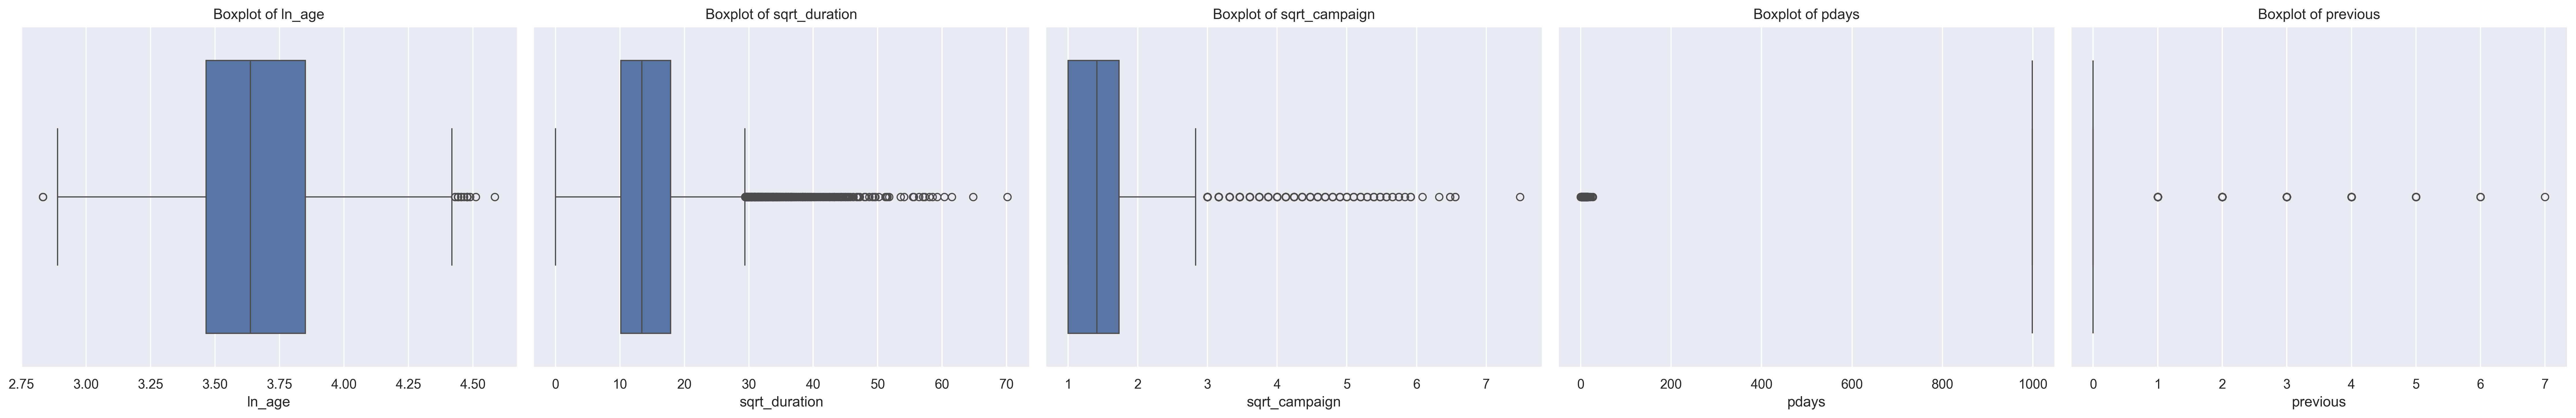

In [7]:
## 异常值检测与处理
# 对于连续数据而言，做箱线图
sns.set_theme(font_scale=1)
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 5), dpi=300)

g_ln_age_box = sns.boxplot(data=data_train, x='ln_age', ax=axes[0])
axes[0].set_title('Boxplot of ln_age')

g_ln_duration_box = sns.boxplot(data=data_train, x='sqrt_duration', ax=axes[1])
axes[1].set_title('Boxplot of sqrt_duration')

g_ln_campaign_box = sns.boxplot(data=data_train, x='sqrt_campaign', ax=axes[2])
axes[2].set_title('Boxplot of sqrt_campaign')

g_pdays_box = sns.boxplot(data=data_train, x='pdays', ax=axes[3])
axes[3].set_title('Boxplot of pdays')

g_previous_box = sns.boxplot(data=data_train, x='previous', ax=axes[4])
axes[4].set_title('Boxplot of previous')

plt.tight_layout()
plt.savefig(fname="连续数据箱线图.png")

#### 3.2.2 3$\sigma$法则

In [8]:
# 3sigma外检测
continuous_columns = ['ln_age', 'sqrt_duration', 'sqrt_campaign', 'pdays', 'previous']

for column in continuous_columns:
    mean_value = data_train[column].mean()
    std_value = data_train[column].std()
    lower_bound = mean_value - 3 * std_value
    upper_bound = mean_value + 3 * std_value
    outlier_count = data_train[(data_train[column] < lower_bound) | (data_train[column] > upper_bound)].shape[0]
    print(f"{column}列3sigma外离群值个数为: {outlier_count}")

ln_age列3sigma外离群值个数为: 81
sqrt_duration列3sigma外离群值个数为: 407
sqrt_campaign列3sigma外离群值个数为: 545
pdays列3sigma外离群值个数为: 1226
previous列3sigma外离群值个数为: 861


#### 3.2.3 异常值处理
变量其异常值具有特殊意义便不做处理
### 3.3 缺失值检测与处理
#### 3.3.1 缺失值情况

In [9]:
## 缺失值检测与处理
print('缺失值情况及比例：')
total_rows = data_train.shape[0]
missing_value_sums = data_train.isnull().sum()
missing_value_proportions = (missing_value_sums / total_rows) * 100

for column, missing_count in missing_value_sums.items():
    proportion = missing_value_proportions[column]
    print(f"{column}: 缺失值数量为 {missing_count}，缺失值比例为 {proportion:.2f}%")

缺失值情况及比例：
age: 缺失值数量为 0，缺失值比例为 0.00%
job: 缺失值数量为 265，缺失值比例为 0.80%
marital: 缺失值数量为 65，缺失值比例为 0.20%
education: 缺失值数量为 1397，缺失值比例为 4.24%
default: 缺失值数量为 6940，缺失值比例为 21.06%
housing: 缺失值数量为 796，缺失值比例为 2.42%
loan: 缺失值数量为 796，缺失值比例为 2.42%
contact: 缺失值数量为 0，缺失值比例为 0.00%
month: 缺失值数量为 0，缺失值比例为 0.00%
day_of_week: 缺失值数量为 0，缺失值比例为 0.00%
duration: 缺失值数量为 0，缺失值比例为 0.00%
campaign: 缺失值数量为 0，缺失值比例为 0.00%
pdays: 缺失值数量为 0，缺失值比例为 0.00%
previous: 缺失值数量为 0，缺失值比例为 0.00%
poutcome: 缺失值数量为 0，缺失值比例为 0.00%
labels: 缺失值数量为 0，缺失值比例为 0.00%
ln_age: 缺失值数量为 0，缺失值比例为 0.00%
sqrt_duration: 缺失值数量为 0，缺失值比例为 0.00%
sqrt_campaign: 缺失值数量为 0，缺失值比例为 0.00%


#### 3.3.2 缺失比例小于5%的处理
直接中位数插补

In [10]:
# 对于缺失比例小于5%，采用中位数直接插补
variables_to_impute = ['job','marital', 'education', 'housing', 'loan']

for variable in variables_to_impute:
    missing_proportion = missing_value_proportions[variable]
    if missing_proportion < 5:
        median_value = data_train[variable].median()
        data_train[variable].fillna(median_value, inplace=True)

#### 3.3.3 缺失值比例在20%左右的处理
先使用WOE将分类数据转换为数值型数据  
再以年龄为依据，对变量进行分组，（13个观测一组左右）  
最后在组内进行中位数插补

In [11]:
# 对于缺失比例较高的default，先用WOE处理，再分组，再在组内使用中位数插补
# WOE
def woe_transformation(data, categorical_cols):
    """
    对指定的分类变量列进行WOE处理

    :param data: 包含数据的DataFrame
    :param categorical_cols: 需要进行WOE处理的分类变量列名列表
    :return: 处理后的DataFrame
    """
    for col in categorical_cols:
        # 对分类变量进行分组并计算好坏样本数
        good_count = data.groupby(col)['labels'].sum()
        total_count = data.groupby(col)['labels'].count()
        bad_count = total_count - good_count

        woe_df = pd.DataFrame({
            'good_count': good_count,
            'total_count': total_count,
            'bad_count': bad_count
        })

        # 计算每组的WOE值
        woe_df['p_good'] = woe_df['good_count'] / woe_df['good_count'].sum()
        woe_df['p_bad'] = woe_df['bad_count'] / woe_df['bad_count'].sum()
        woe_df['WOE'] = np.log(woe_df['p_good'] / woe_df['p_bad'])

        woe_dict = woe_df['WOE'].to_dict()
        data[f'{col}_woe'] = data[col].map(woe_dict)

    return data

categorical_cols = ['job','marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome' ,'labels']
data_train = woe_transformation(data_train, categorical_cols)

# 按年龄分组
min_age = data_train['ln_age'].min()
max_age = data_train['ln_age'].max()
num_groups = 3000

group_width = (max_age - min_age) / num_groups

group_labels = []
for i in range(num_groups):
    lower_bound = min_age + i * group_width
    upper_bound = min_age + (i + 1) * group_width
    group_labels.append(f'Group_{i + 1}: {lower_bound:.2f}-{upper_bound:.2f}')

data_train['age_group'] = pd.cut(data_train['ln_age'], bins=num_groups, labels=group_labels)

# 中位数插补
for group in data_train['age_group'].unique():
    group_data = data_train[data_train['age_group'] == group]
    median_value = group_data['default_woe'].median()
    data_train.loc[(data_train['age_group'] == group) & (data_train['default_woe'].isnull()), 'default_woe'] = median_value

data_train = data_train.drop(columns=['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
                                      'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
                                      'poutcome', 'labels_woe','age_group'])

data_train['default_woe'] = data_train['default_woe'].median()

### 3.4 变量过滤
#### 3.4.1 低方差过滤法

In [12]:
## 变量过滤
# 低方差过滤法
from sklearn.feature_selection import VarianceThreshold

threshold = 0.05 # 阈值

selector = VarianceThreshold(threshold=threshold)
selector.fit(data_train.drop('labels', axis=1))

selected_columns = data_train.drop('labels', axis=1).columns[selector.get_support()]

data_train_low_var = data_train[['labels'] + list(selected_columns)]

print("经过低方差过滤后的数据形状：", data_train_low_var.shape)
data_train_low_var.head()

经过低方差过滤后的数据形状： (32950, 9)


,labels,previous,ln_age,sqrt_duration,sqrt_campaign,job_woe,contact_woe,month_woe,poutcome_woe
0,0,0,3.891820,15.066519,2.000000,-0.534972,0.305771,-0.115089,-0.274233
1,0,1,3.610918,14.212670,1.414214,-0.209699,-0.819483,-0.115089,0.281971
2,1,0,4.356709,33.882149,1.000000,0.990506,0.305771,-0.221816,-0.274233
3,0,0,3.583519,10.954451,1.414214,0.151384,-0.819483,-0.627514,-0.274233
4,0,0,4.077537,19.183326,1.414214,0.990506,0.305771,-0.091391,-0.274233


通过低方差过滤法，将15个输入变量减少为9个输入变量
#### 3.4.2 高相关过滤法

In [13]:
# 高相关过滤法
corr_matrix = data_train_low_var.drop('labels', axis=1).corr()
corr_threshold = 0.8 # 阈值

columns_to_drop = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > corr_threshold:
            columns_to_drop.append(corr_matrix.columns[j])

columns_to_drop = list(set(columns_to_drop))

data_train = data_train_low_var.drop(columns=columns_to_drop)

print("经过高相关过滤后的数据形状：", data_train.shape)
data_train.head()

经过高相关过滤后的数据形状： (32950, 9)


,labels,previous,ln_age,sqrt_duration,sqrt_campaign,job_woe,contact_woe,month_woe,poutcome_woe
0,0,0,3.891820,15.066519,2.000000,-0.534972,0.305771,-0.115089,-0.274233
1,0,1,3.610918,14.212670,1.414214,-0.209699,-0.819483,-0.115089,0.281971
2,1,0,4.356709,33.882149,1.000000,0.990506,0.305771,-0.221816,-0.274233
3,0,0,3.583519,10.954451,1.414214,0.151384,-0.819483,-0.627514,-0.274233
4,0,0,4.077537,19.183326,1.414214,0.990506,0.305771,-0.091391,-0.274233


高相关过滤法并没有继续过滤变量
### 3.5 变量聚类
#### 3.5.1 计算输入的皮尔森相关系数

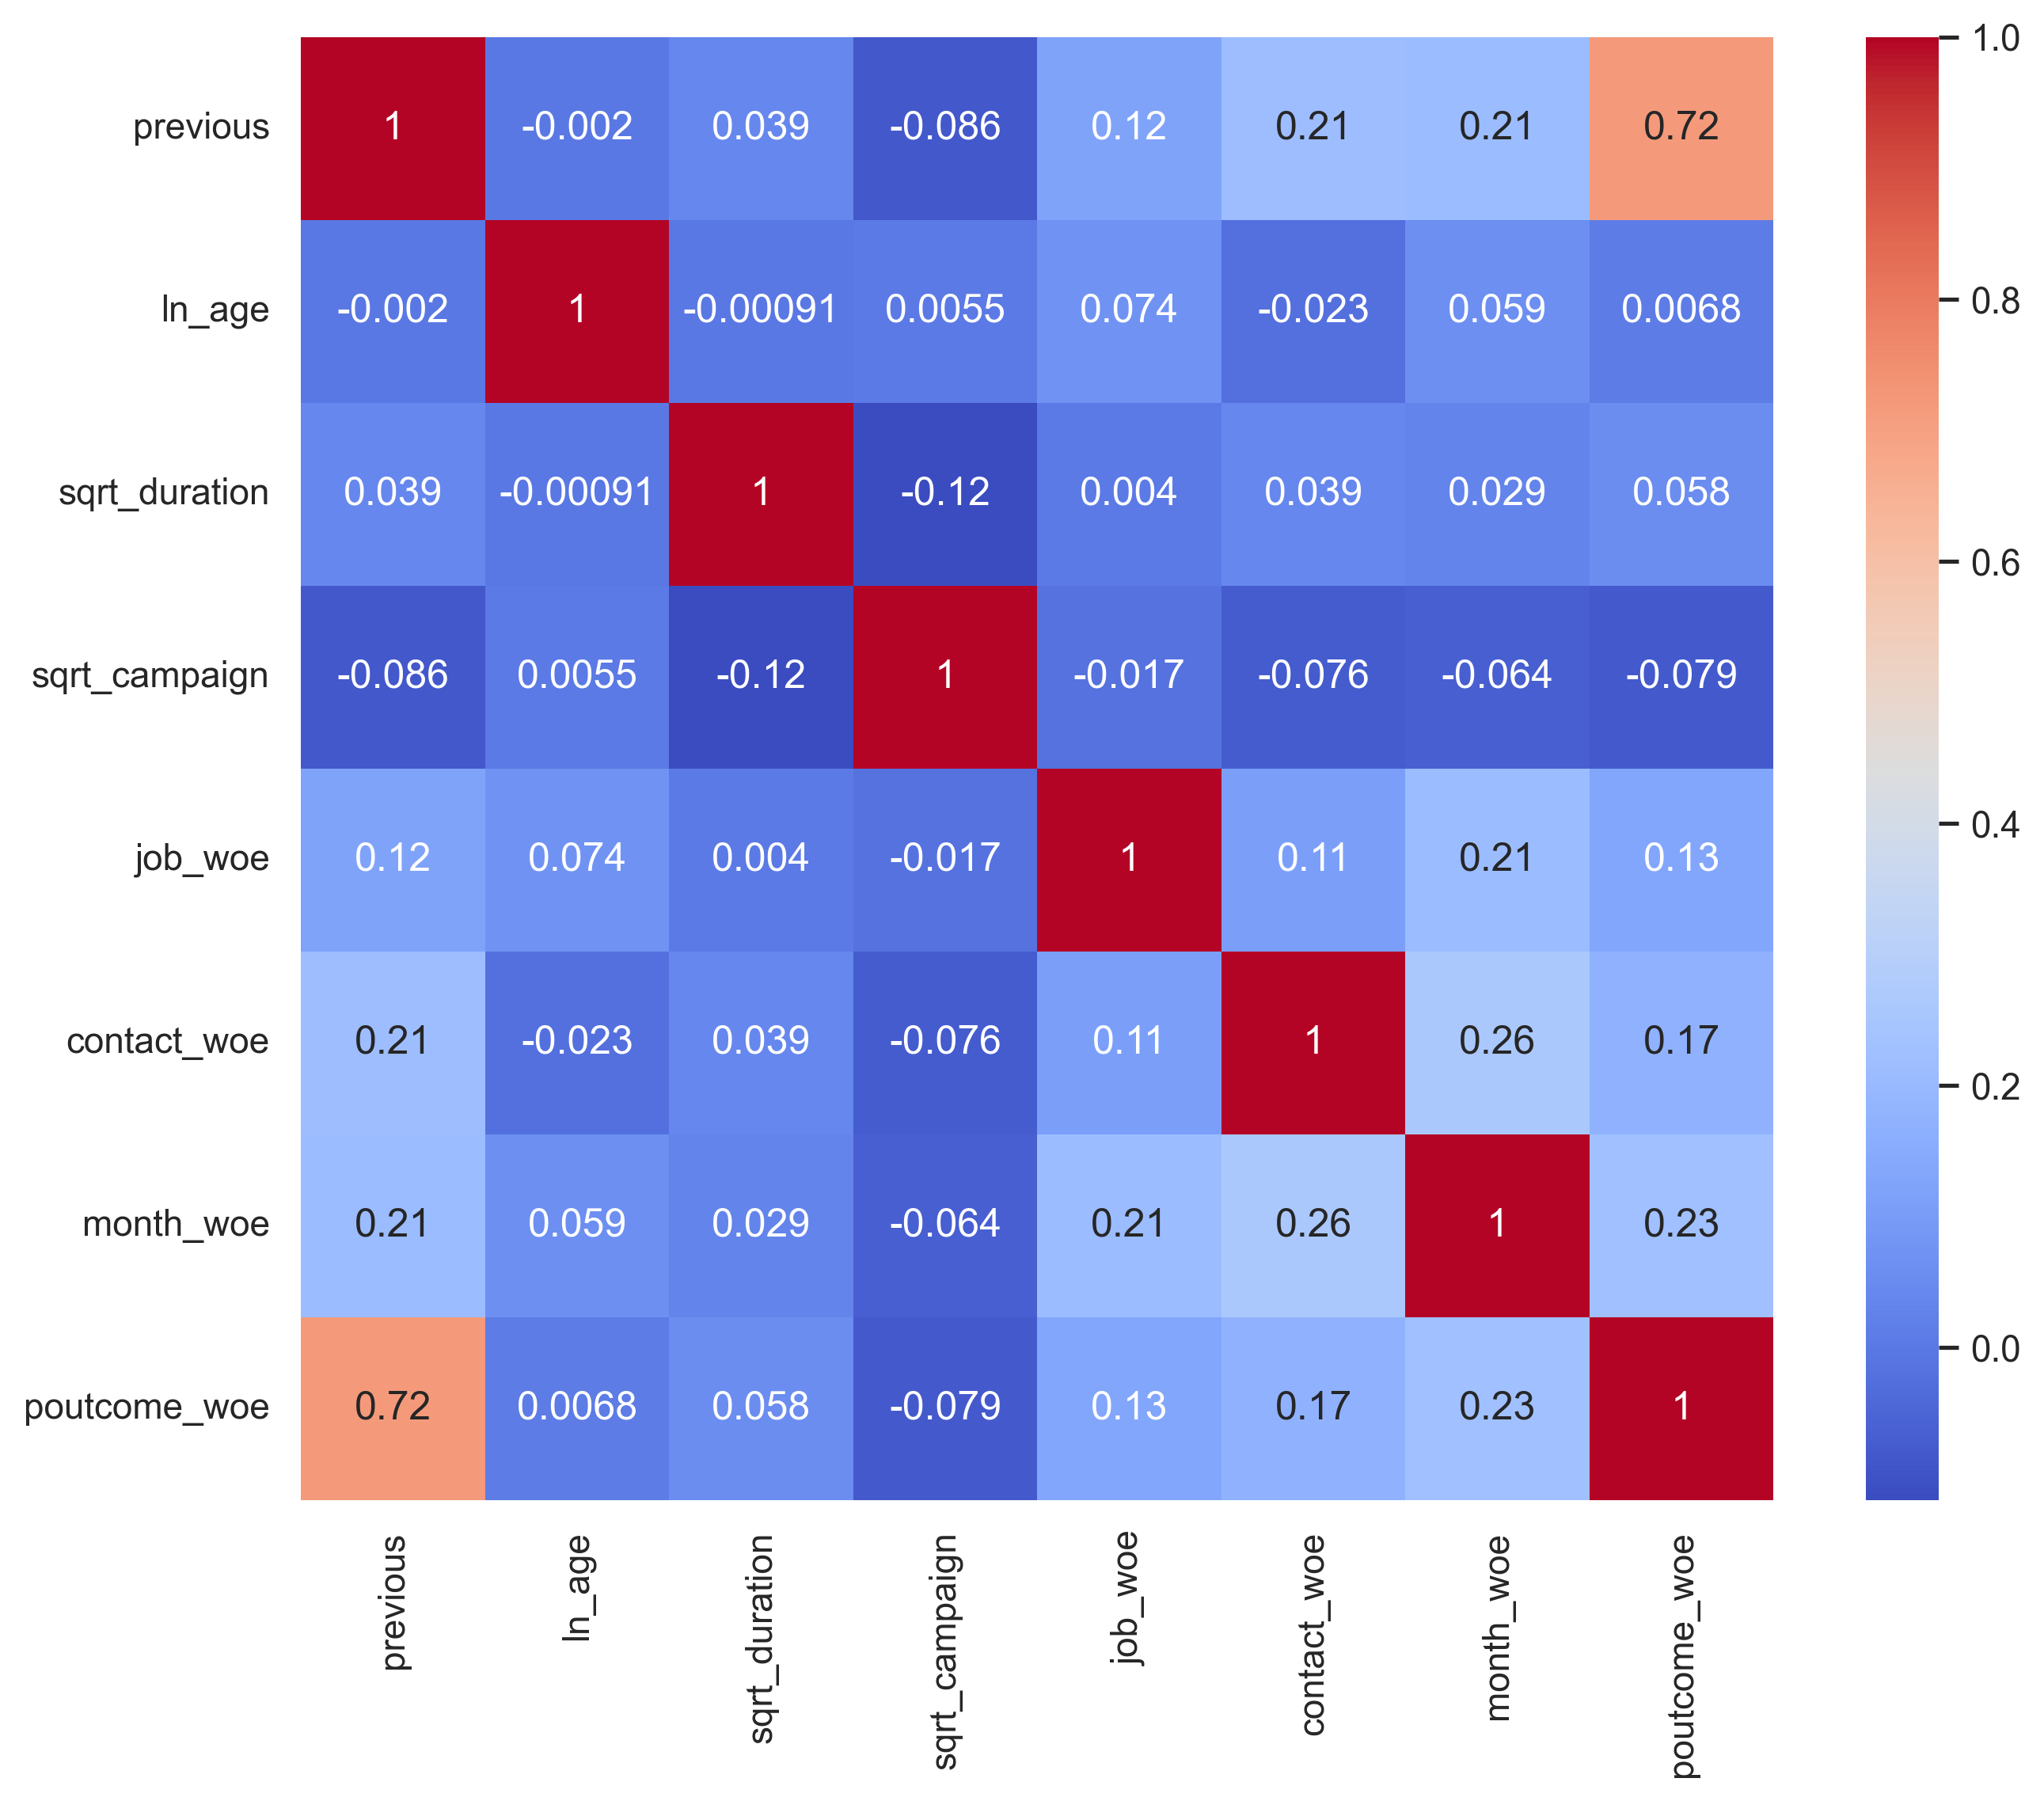

In [14]:
## 变量聚类
# 计算相关系数
input_vars = data_train.drop('labels', axis=1)
corr_matrix = input_vars.corr() # 皮尔森相关系数

# 绘制热图
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
g.set_xticklabels(g.get_xticklabels(), fontsize=12)
g.set_yticklabels(g.get_yticklabels(), fontsize=12)
plt.savefig(fname="输入变量相关系数热图.png")

可以看出'previous'和WOE变换后的'poutcome'相关性强，他们都代表过去活动参与情况，因此进一步给这两个指标提取主成分并命名【past】表示客户的过去的表现影响
#### 3.5.2 PCA降维
从方差贡献率上来看，提取一个主成分的效果较好

In [15]:
# 主成分降维
from sklearn.decomposition import PCA

X = data_train[['previous', 'poutcome_woe']]

pca = PCA(n_components=1) # 保留一个主成分
X_pca = pca.fit_transform(X)

variance_contribution = pca.explained_variance_ratio_[0]
print("第一个主成分的方差贡献率：", variance_contribution)

data_train['past'] = X_pca.flatten()
data_train = data_train.drop(columns=['previous', 'poutcome_woe'])

data_train.head()

第一个主成分的方差贡献率： 0.8607462898891375


,labels,ln_age,sqrt_duration,sqrt_campaign,job_woe,contact_woe,month_woe,past
0,0,3.891820,15.066519,2.000000,-0.534972,0.305771,-0.115089,-0.233184
1,0,3.610918,14.212670,1.414214,-0.209699,-0.819483,-0.115089,0.844753
2,1,4.356709,33.882149,1.000000,0.990506,0.305771,-0.221816,-0.233184
3,0,3.583519,10.954451,1.414214,0.151384,-0.819483,-0.627514,-0.233184
4,0,4.077537,19.183326,1.414214,0.990506,0.305771,-0.091391,-0.233184


## 四、不平稳数据处理
### 4.1 数据比例情况
可以去除数据存在不平衡的情况

In [16]:
#--------------------------------4、不平稳数据处理--------------------------------#
from imblearn.over_sampling import SMOTE

## 比例计算
label_counts = data_train['labels'].value_counts()
total_samples = label_counts.sum()
proportion_0 = label_counts[0] / total_samples
proportion_1 = label_counts[1] / total_samples

print(f"labels中【没订阅】的比例为: {proportion_0:.2f}")
print(f"labels中【订阅】的比例为: {proportion_1:.2f}")

labels中【没订阅】的比例为: 0.89
labels中【订阅】的比例为: 0.11


### 4.2 SMOTE过采样

In [17]:
# 过采样SMOTE
X = data_train.drop('labels', axis=1)
y = data_train['labels']

smote = SMOTE()

X_resampled, y_resampled = smote.fit_resample(X, y)

data_train_resampled = pd.concat([X_resampled, y_resampled], axis=1)

label_counts_resampled = data_train_resampled['labels'].value_counts()
total_samples_resampled = label_counts_resampled.sum()
proportion_0_resampled = label_counts_resampled[0] / total_samples_resampled
proportion_1_resampled = label_counts_resampled[1] / total_samples_resampled

print(f"过采样后labels中【没订阅】的比例为: {proportion_0_resampled:.2f}")
print(f"过采样后labels中【订阅】的比例为: {proportion_1_resampled:.2f}")

过采样后labels中【没订阅】的比例为: 0.50
过采样后labels中【订阅】的比例为: 0.50


## 五、模型调参与预测
### 5.1 划分数据
将数据分为训练集70%和测试集30%

In [18]:
#--------------------------------5、模型选择与评估--------------------------------#
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier,VotingClassifier

## 划分数据
X = data_train_resampled.drop('labels', axis=1)
y = data_train_resampled['labels']

# 训练集70% 测试集30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("训练集特征形状:", X_train.shape)
print("训练集标签形状:", y_train.shape)
print("测试集特征形状:", X_test.shape)
print("测试集标签形状:", y_test.shape)

训练集特征形状: (40933, 7)
训练集标签形状: (40933,)
测试集特征形状: (17543, 7)
测试集标签形状: (17543,)


<a id="1"></a>
### 5.2 Stacking
Stacking+RandomForest/svm/HistGradientBoosting
#### 5.2.1 网格搜索HistGradientBoosting最佳参数

In [19]:
## Stacking
# 网格搜索
hgb = HistGradientBoostingClassifier(verbose=0)

paparam_grid = {
    'learning_rate' : [0.3,0.5],
    'max_leaf_nodes' : [3, 5], # 默认 31
    'l2_regularization' : [0.01, 0.1],
    'max_bins' : [200, 255], # 默认 255
    
}

# 创建网格搜索对象
clf = GridSearchCV(
    estimator=hgb,
    param_grid=paparam_grid,
    scoring='accuracy',  # 使用准确率作为评估指标
    cv=5,  # 5折交叉验证
    n_jobs=-1  # 使用所有可用的CPU核心进行并行计算
)

clf.fit(X_train, y_train)

# 获取最佳参数
best_params = clf.best_params_
print("HGB最佳参数:", best_params)

# 获取最佳模型
best_model = clf.best_estimator_

# 获取最佳得分（在交叉验证集上的平均准确率）
best_score = clf.best_score_
print("HGB最佳得分:", best_score)

HGB最佳参数: {'l2_regularization': 0.1, 'learning_rate': 0.5, 'max_bins': 255, 'max_leaf_nodes': 5}
HGB最佳得分: 0.9342583396994592


#### 5.2.2 模型组合与拟合

In [20]:
# 模型拟合
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', make_pipeline(StandardScaler(),
                        SVC(random_state=42,kernel='rbf'))),
    ('hgb', clf.best_estimator_)
]

stacking = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(X_train, y_train).score(X_test, y_test)

0.9350168158239753

#### 5.2.3 模型评估
##### 准确率Accuracy
正确分类的样本数占总样本数的比例
$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$
##### 精确率precision
被分类器预测为正类的样本中，真正为正类的样本所占的比例
$$Precision = \frac{TP}{TP+FP}$$
##### 召回率recall
真正为正类的样本中，被分类器预测为正类的样本所占的比例
$$Recall = \frac{TP}{TP+FN}$$
##### F1值f1score
综合考虑精确率和召回率，精确率和召回率的调和平均数
$$F1 = \frac{2 Precision Recall}{Precision+Recall}$$

In [21]:
## 模型评估
y_stacking_pred = clf.predict(X_test)

# 准确率Accuracy--正确分类的样本数占总样本数的比例
accuracy = accuracy_score(y_test, y_stacking_pred)
print("stacking预测准确率:", accuracy)

# 精确率precision--被分类器预测为正类的样本中，真正为正类的样本所占的比例
# 召回率recall--真正为正类的样本中，被分类器预测为正类的样本所占的比例
# F1值f1score--综合考虑精确率和召回率，精确率和召回率的调和平均数
print(classification_report(y_test, y_stacking_pred))

stacking预测准确率: 0.9350168158239753
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      8752
           1       0.94      0.93      0.93      8791

    accuracy                           0.94     17543
   macro avg       0.94      0.94      0.94     17543
weighted avg       0.94      0.94      0.94     17543



#### 5.2.4 混淆矩阵

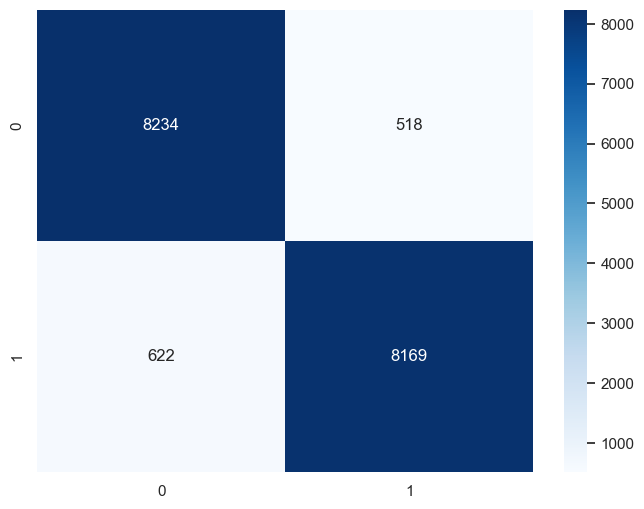

In [22]:
## 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_stacking_pred)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="stacking混淆矩阵.png")

#### 5.2.5 Lift曲线

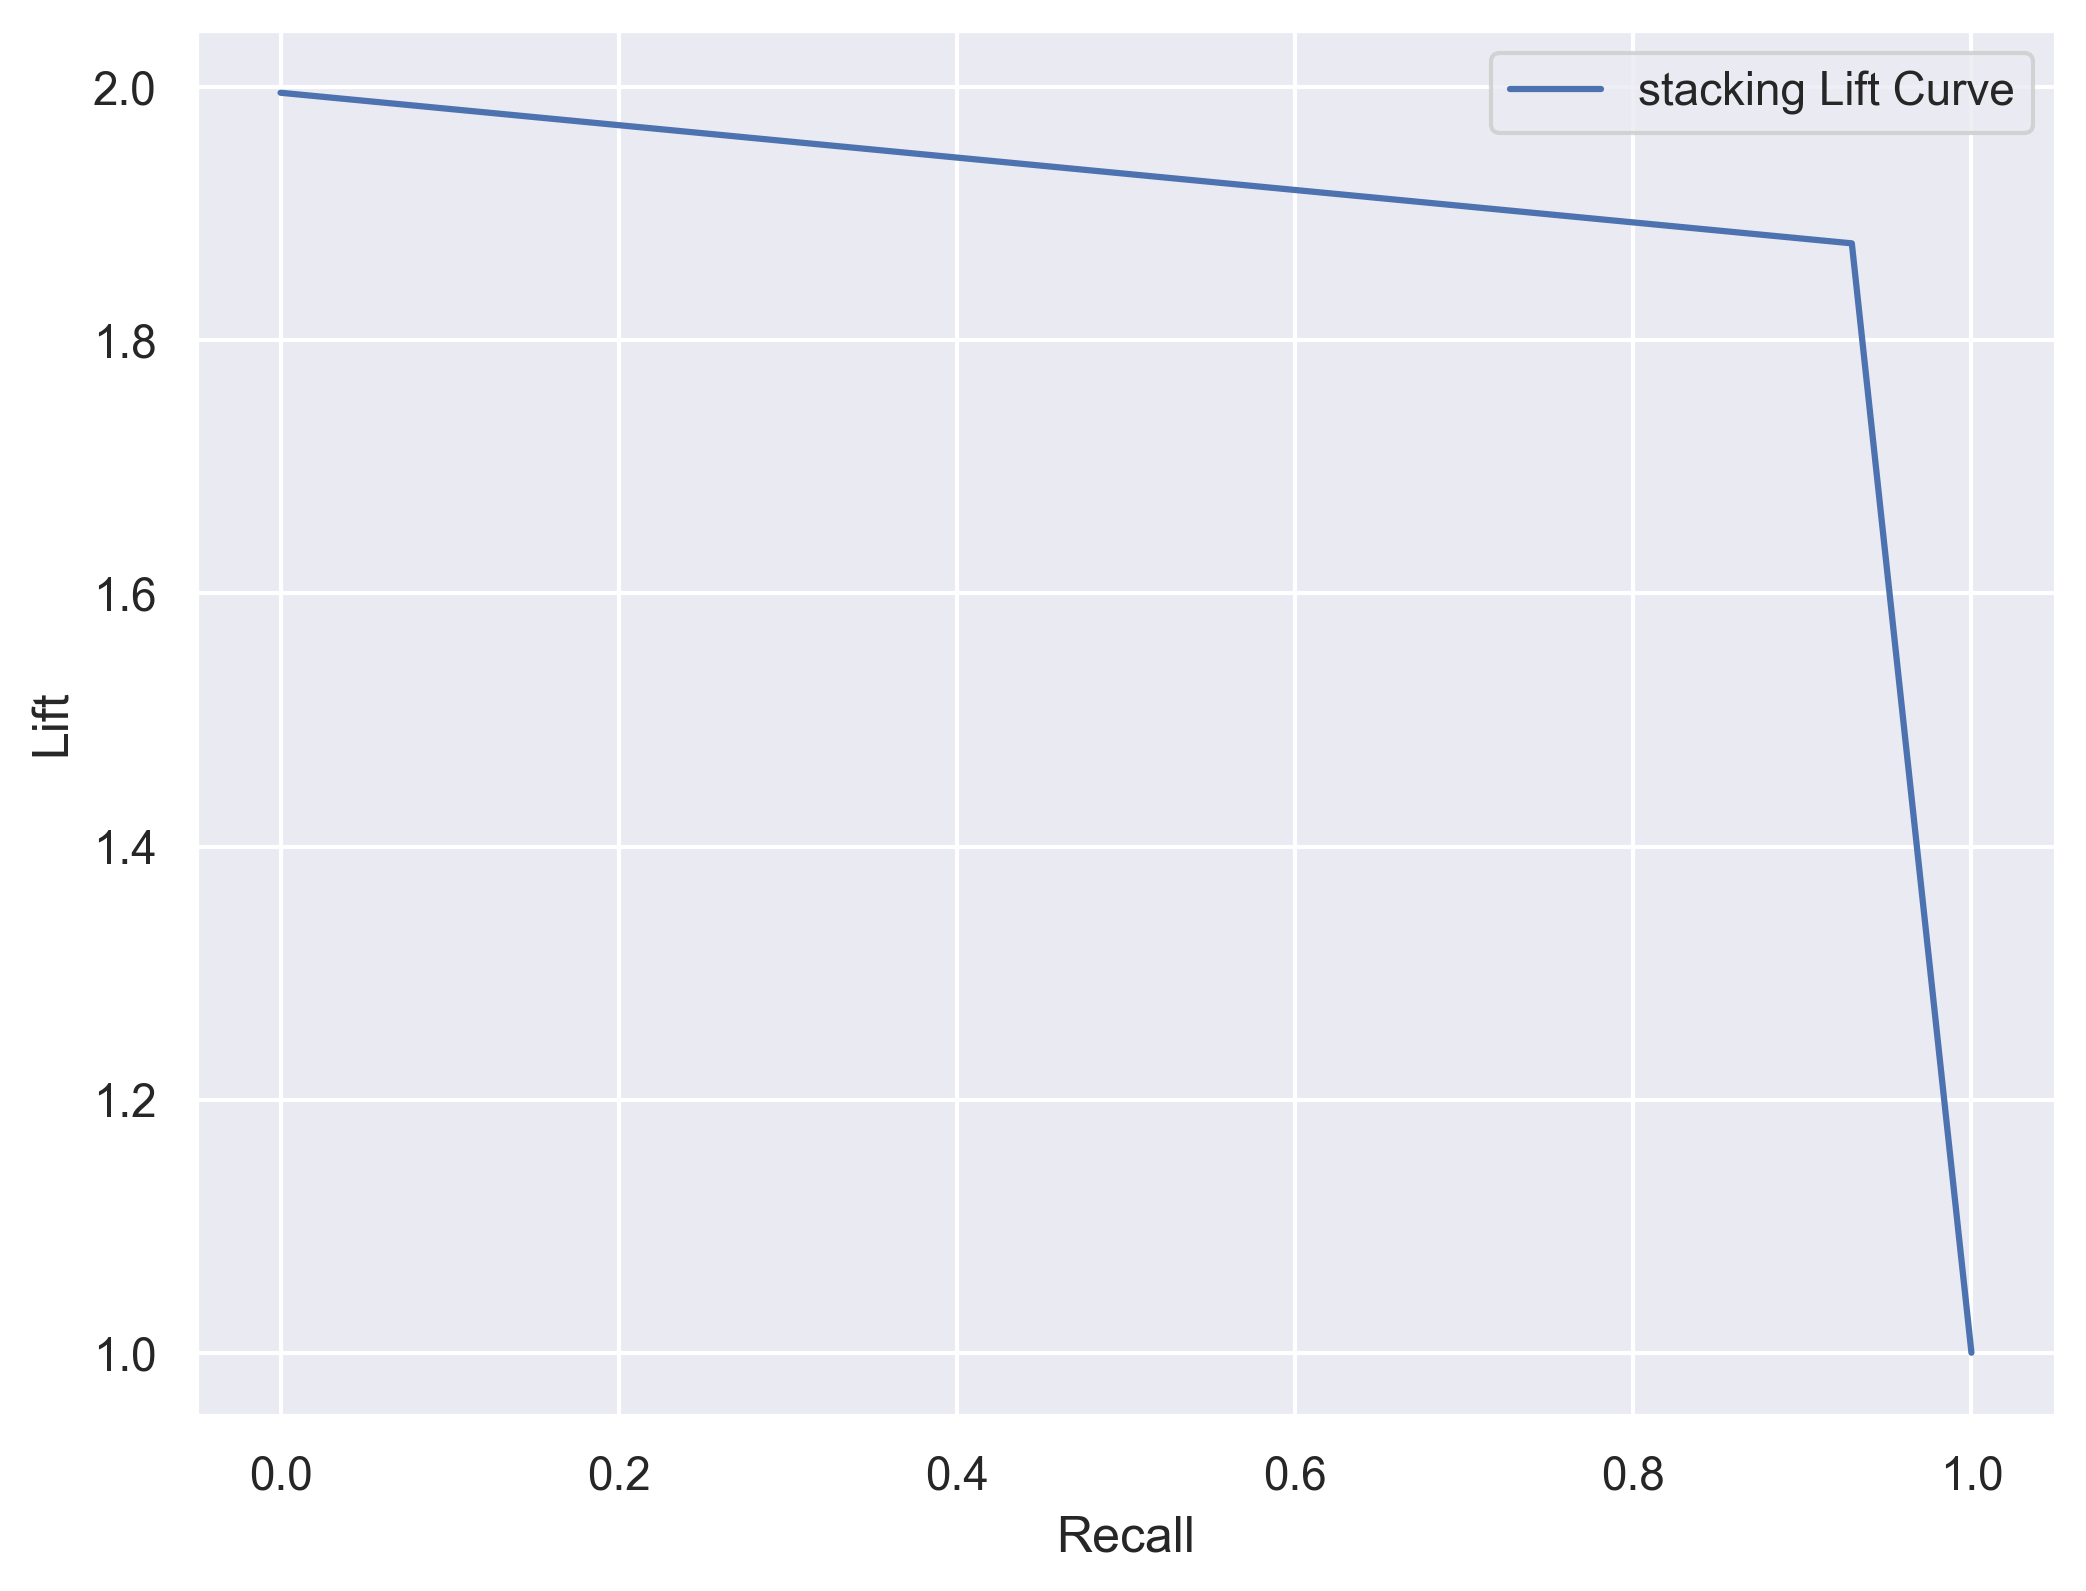

In [23]:
## lift曲线
precision_stacking, recall_stacking, thresholds_stacking = precision_recall_curve(y_test, y_stacking_pred)

lift_stacking = precision_stacking / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi = 300)
plt.plot(recall_stacking, lift_stacking, label='stacking Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.legend()
plt.savefig(fname="stacking-Lift曲线.png")

### 5.3 Voting
Voting+RandomForest/svm/HistGradientBoosting
#### 5.3.1 网格搜索HistGradientBoosting最佳参数

In [24]:
## Voting
# 网格搜索
hgb = HistGradientBoostingClassifier(verbose=0)

paparam_grid = {
    'learning_rate' : [0.3,0.5],
    'max_leaf_nodes' : [3, 5], # 默认 31
    'l2_regularization' : [0.01, 0.1],
    'max_bins' : [200, 255], # 默认 255
    
}

# 创建网格搜索对象
clf = GridSearchCV(
    estimator=hgb,
    param_grid=paparam_grid,
    scoring='accuracy',  # 使用准确率作为评估指标
    cv=5,  # 5折交叉验证
    n_jobs=-1  # 使用所有可用的CPU核心进行并行计算
)

clf.fit(X_train, y_train)

# 获取最佳参数
best_params = clf.best_params_
print("HGB最佳参数:", best_params)

# 获取最佳模型
best_model = clf.best_estimator_

# 获取最佳得分（在交叉验证集上的平均准确率）
best_score = clf.best_score_
print("HGB最佳得分:", best_score)

HGB最佳参数: {'l2_regularization': 0.1, 'learning_rate': 0.5, 'max_bins': 255, 'max_leaf_nodes': 5}
HGB最佳得分: 0.9353088243233069


#### 5.3.2 模型组合与拟合
有软投票和硬投票

In [25]:
# 模型拟合
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', make_pipeline(StandardScaler(),
                        SVC(random_state=42,kernel='rbf'))),
    ('hgb', clf.best_estimator_)
]

voting = VotingClassifier(
    estimators=estimators, voting='hard'
)

clf.fit(X_train, y_train).score(X_test, y_test)

0.9323946873396797

#### 5.3.3 模型评估
##### 准确率Accuracy
正确分类的样本数占总样本数的比例
$$
Accuracy = \frac{TP+TN}{TP+TN+FP+FN}
$$
##### 精确率precision
被分类器预测为正类的样本中，真正为正类的样本所占的比例
$$Precision = \frac{TP}{TP+FP}$$
##### 召回率recall
真正为正类的样本中，被分类器预测为正类的样本所占的比例
$$Recall = \frac{TP}{TP+FN}$$
##### F1值f1score
综合考虑精确率和召回率，精确率和召回率的调和平均数
$$F1 = \frac{2 Precision Recall}{Precision+Recall}$$

In [26]:
## 模型评估
y_voting_pred = clf.predict(X_test)

# 准确率Accuracy--正确分类的样本数占总样本数的比例
accuracy = accuracy_score(y_test, y_voting_pred)
print("voting预测准确率:", accuracy)

# 精确率precision--被分类器预测为正类的样本中，真正为正类的样本所占的比例
# 召回率recall--真正为正类的样本中，被分类器预测为正类的样本所占的比例
# F1值f1score--综合考虑精确率和召回率，精确率和召回率的调和平均数
print(classification_report(y_test, y_voting_pred))


voting预测准确率: 0.9323946873396797
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      8752
           1       0.94      0.93      0.93      8791

    accuracy                           0.93     17543
   macro avg       0.93      0.93      0.93     17543
weighted avg       0.93      0.93      0.93     17543



#### 5.3.4 混淆矩阵

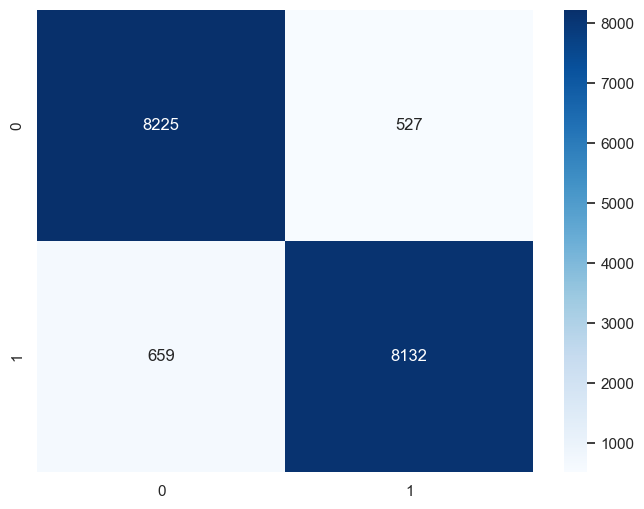

In [27]:
## 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_voting_pred)

# 使用seaborn绘制混淆矩阵热图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.savefig(fname="voting混淆矩阵.png")

#### 5.3.4 Lift曲线

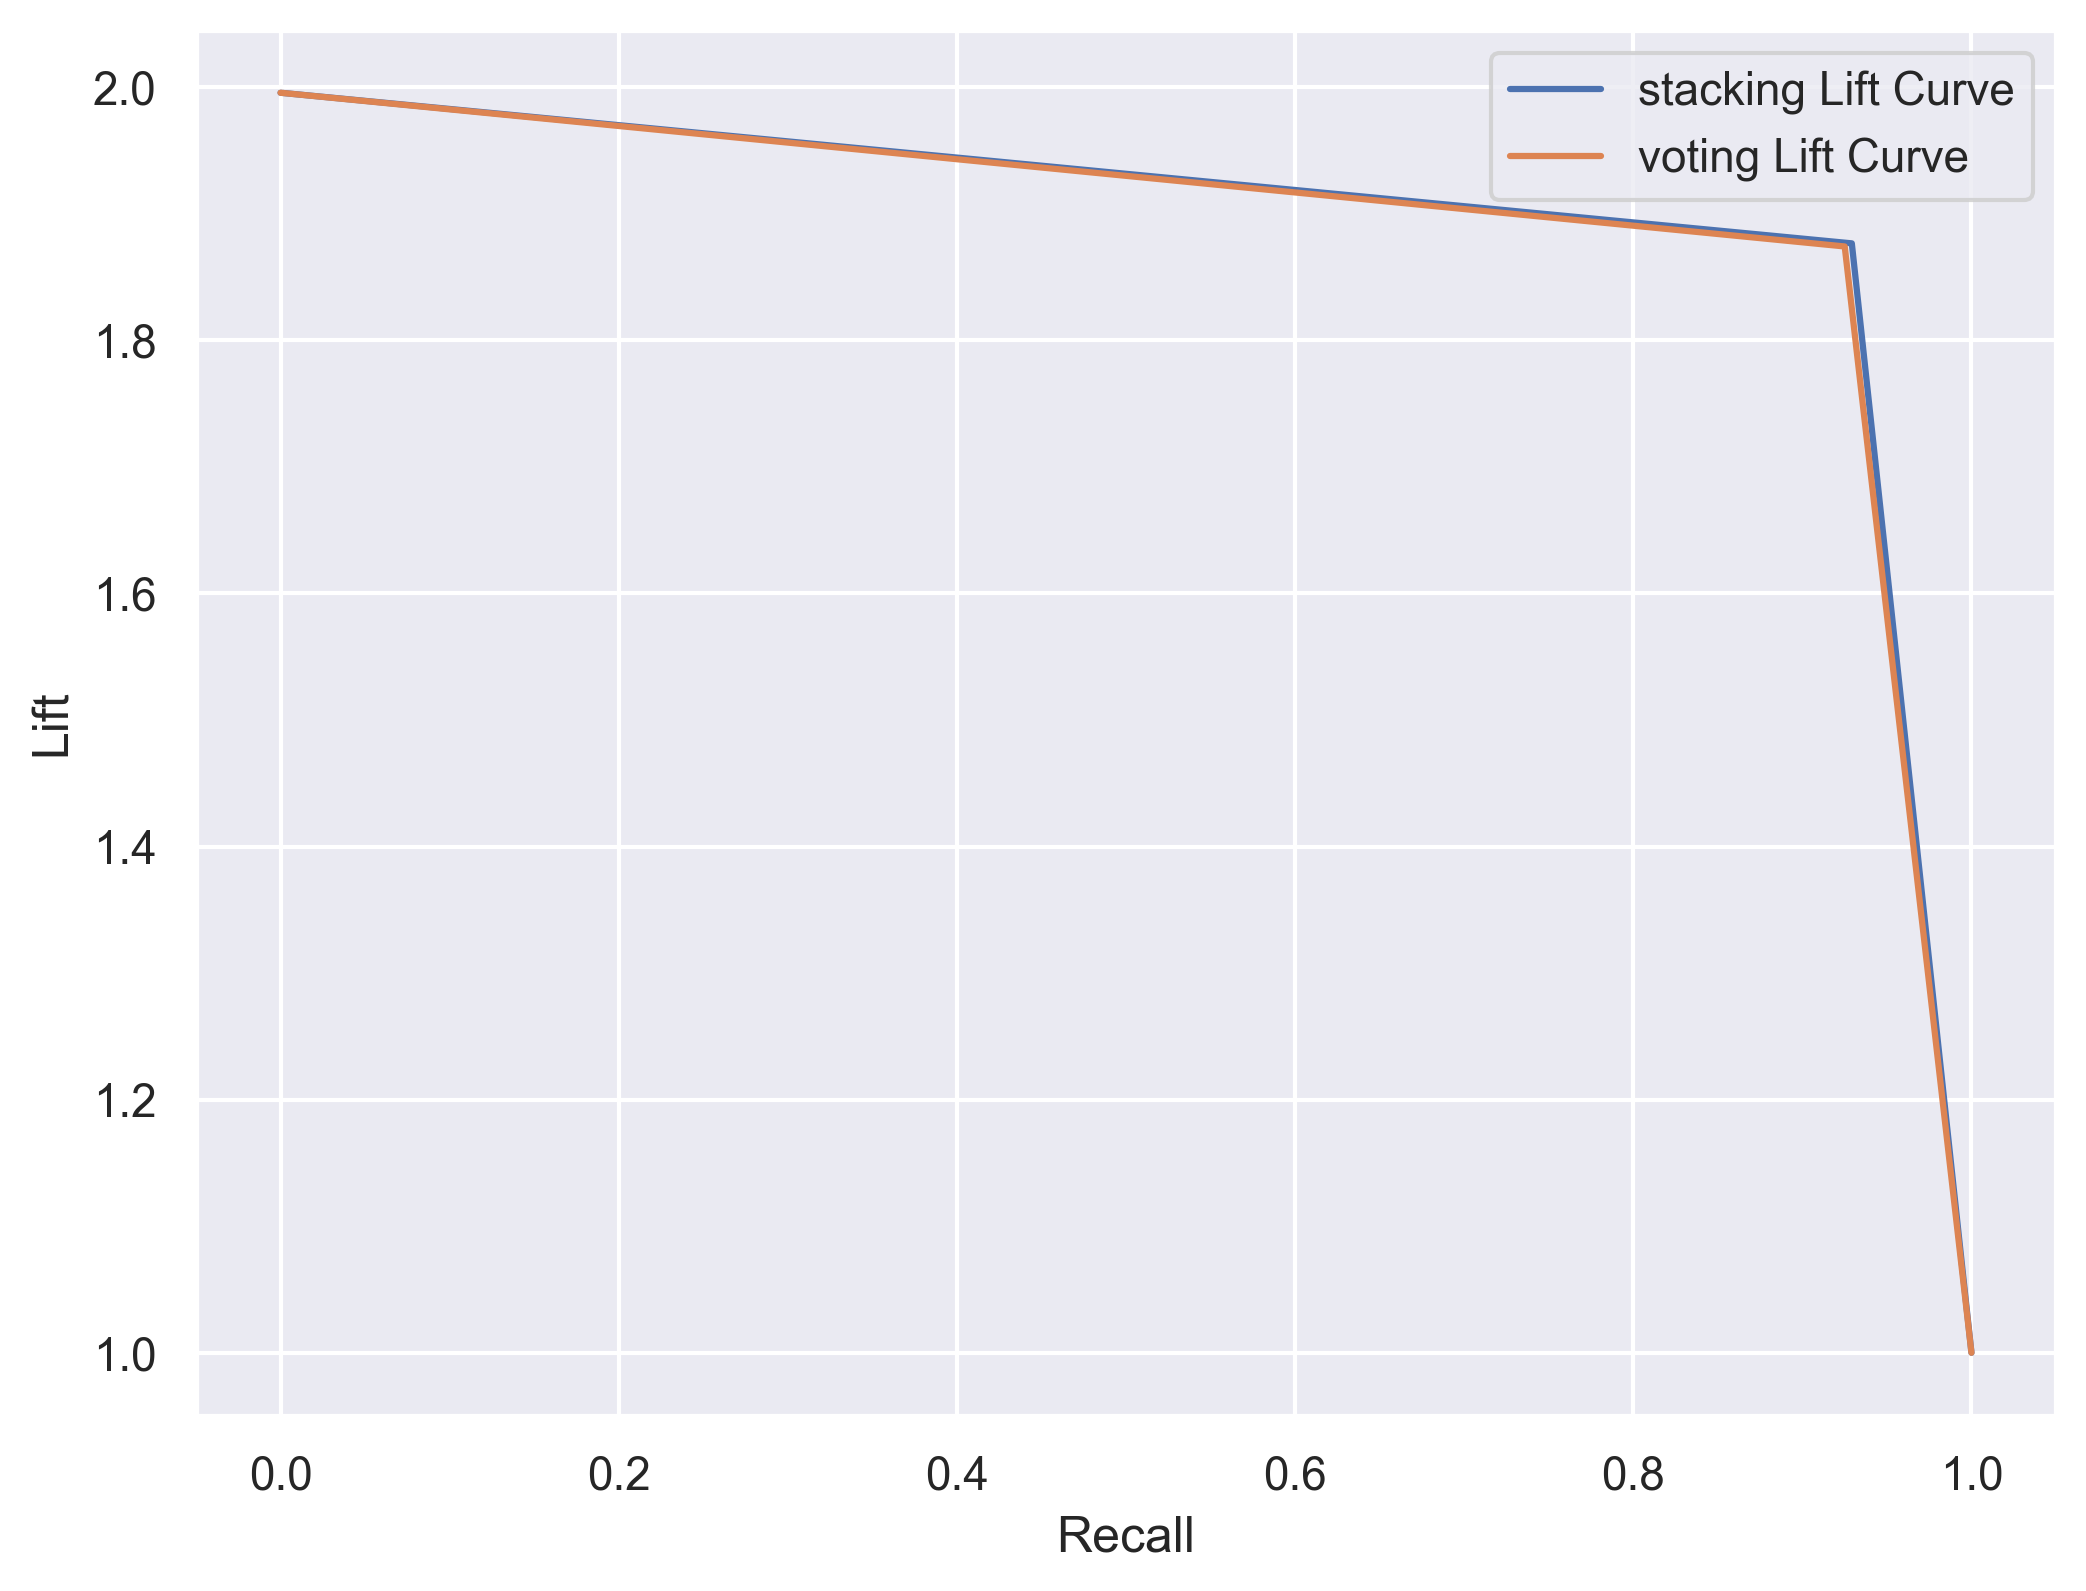

In [28]:
## lift曲线
precision_voting, recall_voting, thresholds_voting = precision_recall_curve(y_test, y_voting_pred)

lift_voting = precision_voting / (y_test.sum() / len(y_test))

plt.figure(figsize=(8, 6), dpi = 300)
plt.plot(recall_stacking, lift_stacking, label='stacking Lift Curve')
plt.plot(recall_voting, lift_voting, label='voting Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.legend()
plt.savefig(fname="voting-Lift曲线.png")

<a id="2"></a>
## 六、Ensemble Learning全部方法结果对比
我作业15、作业16、作业17用的一个数据集，在同一数据集下对比AdaBoost、XGBoost、LightGBM、Bagging、Random Forest、Stacking、Voting

In [32]:
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import BaggingClassifier

# logistic
logistic_model = LogisticRegression(C=0.5, penalty='l1', solver='liblinear')
logistic_model.fit(X_train, y_train)
y_logistic_pred = logistic_model.predict(X_test)

precision_Logistic, recall_Logistic, thresholds_Logistic = precision_recall_curve(y_test, y_logistic_pred)
lift_Logistic = precision_Logistic / (y_test.sum() / len(y_test))

# AdaBoost
param_grid = {
    'n_estimators': [30],
    'learning_rate': [0.5], 
    'estimator__C': [4.5] 
}

base_estimator = LogisticRegression(penalty='l2', C=0.01, solver='lbfgs')
model = AdaBoostClassifier(estimator=base_estimator, algorithm='SAMME')

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy', 
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

AdaBoost_model = grid_search.best_estimator_
y_AdaBoost_pred = AdaBoost_model.predict(X_test)

precision_adLogistic, recall_adLogistic, thresholds_adLogistic = precision_recall_curve(y_test, y_AdaBoost_pred)
lift_adLogistic = precision_adLogistic / (y_test.sum() / len(y_test))

# XGBoost
param_grid = {
    'n_estimators': [150],
    'learning_rate': [0.2],
    'max_depth': [5],
    'gamma': [0.1]
}

xgb_model = xgb.XGBClassifier(objective='binary:logistic')

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)
best_model_xgb = grid_search_xgb.best_estimator_
y_best_pred_xgb = best_model_xgb.predict(X_test)

precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_best_pred_xgb)
lift_xgb = precision_xgb / (y_test.sum() / len(y_test))

# LightGBM
param_grid = {
    'n_estimators': [150],
    'learning_rate': [0.2],
    'num_leaves': [30],
    'min_child_samples': [20]
}

lgb_model = lgb.LGBMClassifier(objective='binary')

grid_search_lgb = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1 
)

grid_search_lgb.fit(X_train, y_train)
best_model_lgb = grid_search_lgb.best_estimator_
y_best_pred_lgb = best_model_lgb.predict(X_test)

precision_lgb, recall_lgb, thresholds_lgb = precision_recall_curve(y_test, y_best_pred_lgb)
lift_lgb = precision_lgb / (y_test.sum() / len(y_test))

## bagging
base_estimators = [
    ('dt', DecisionTreeClassifier()),
    ('svc', SVC(probability=True)),
    ('lr', LogisticRegression())
]

bag_model = BaggingClassifier(
    estimator=None,
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)

bag_model.estimators_ = [est[1] for est in base_estimators]
bag_model.fit(X_train, y_train)
y_bag_pred = bag_model.predict(X_test)

precision_bag, recall_bag, thresholds_bag = precision_recall_curve(y_test, y_bag_pred)
lift_bag = precision_bag / (y_test.sum() / len(y_test))

## random forest
rf_model = RandomForestClassifier(n_estimators=1000, 
                max_depth=20,
                n_jobs=-1, oob_score=True, random_state=10)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_rf)
lift_rf = precision_rf / (y_test.sum() / len(y_test))

[LightGBM] [Info] Number of positive: 20447, number of negative: 20486
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1650
[LightGBM] [Info] Number of data points in the train set: 40933, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499524 -> initscore=-0.001906
[LightGBM] [Info] Start training from score -0.001906


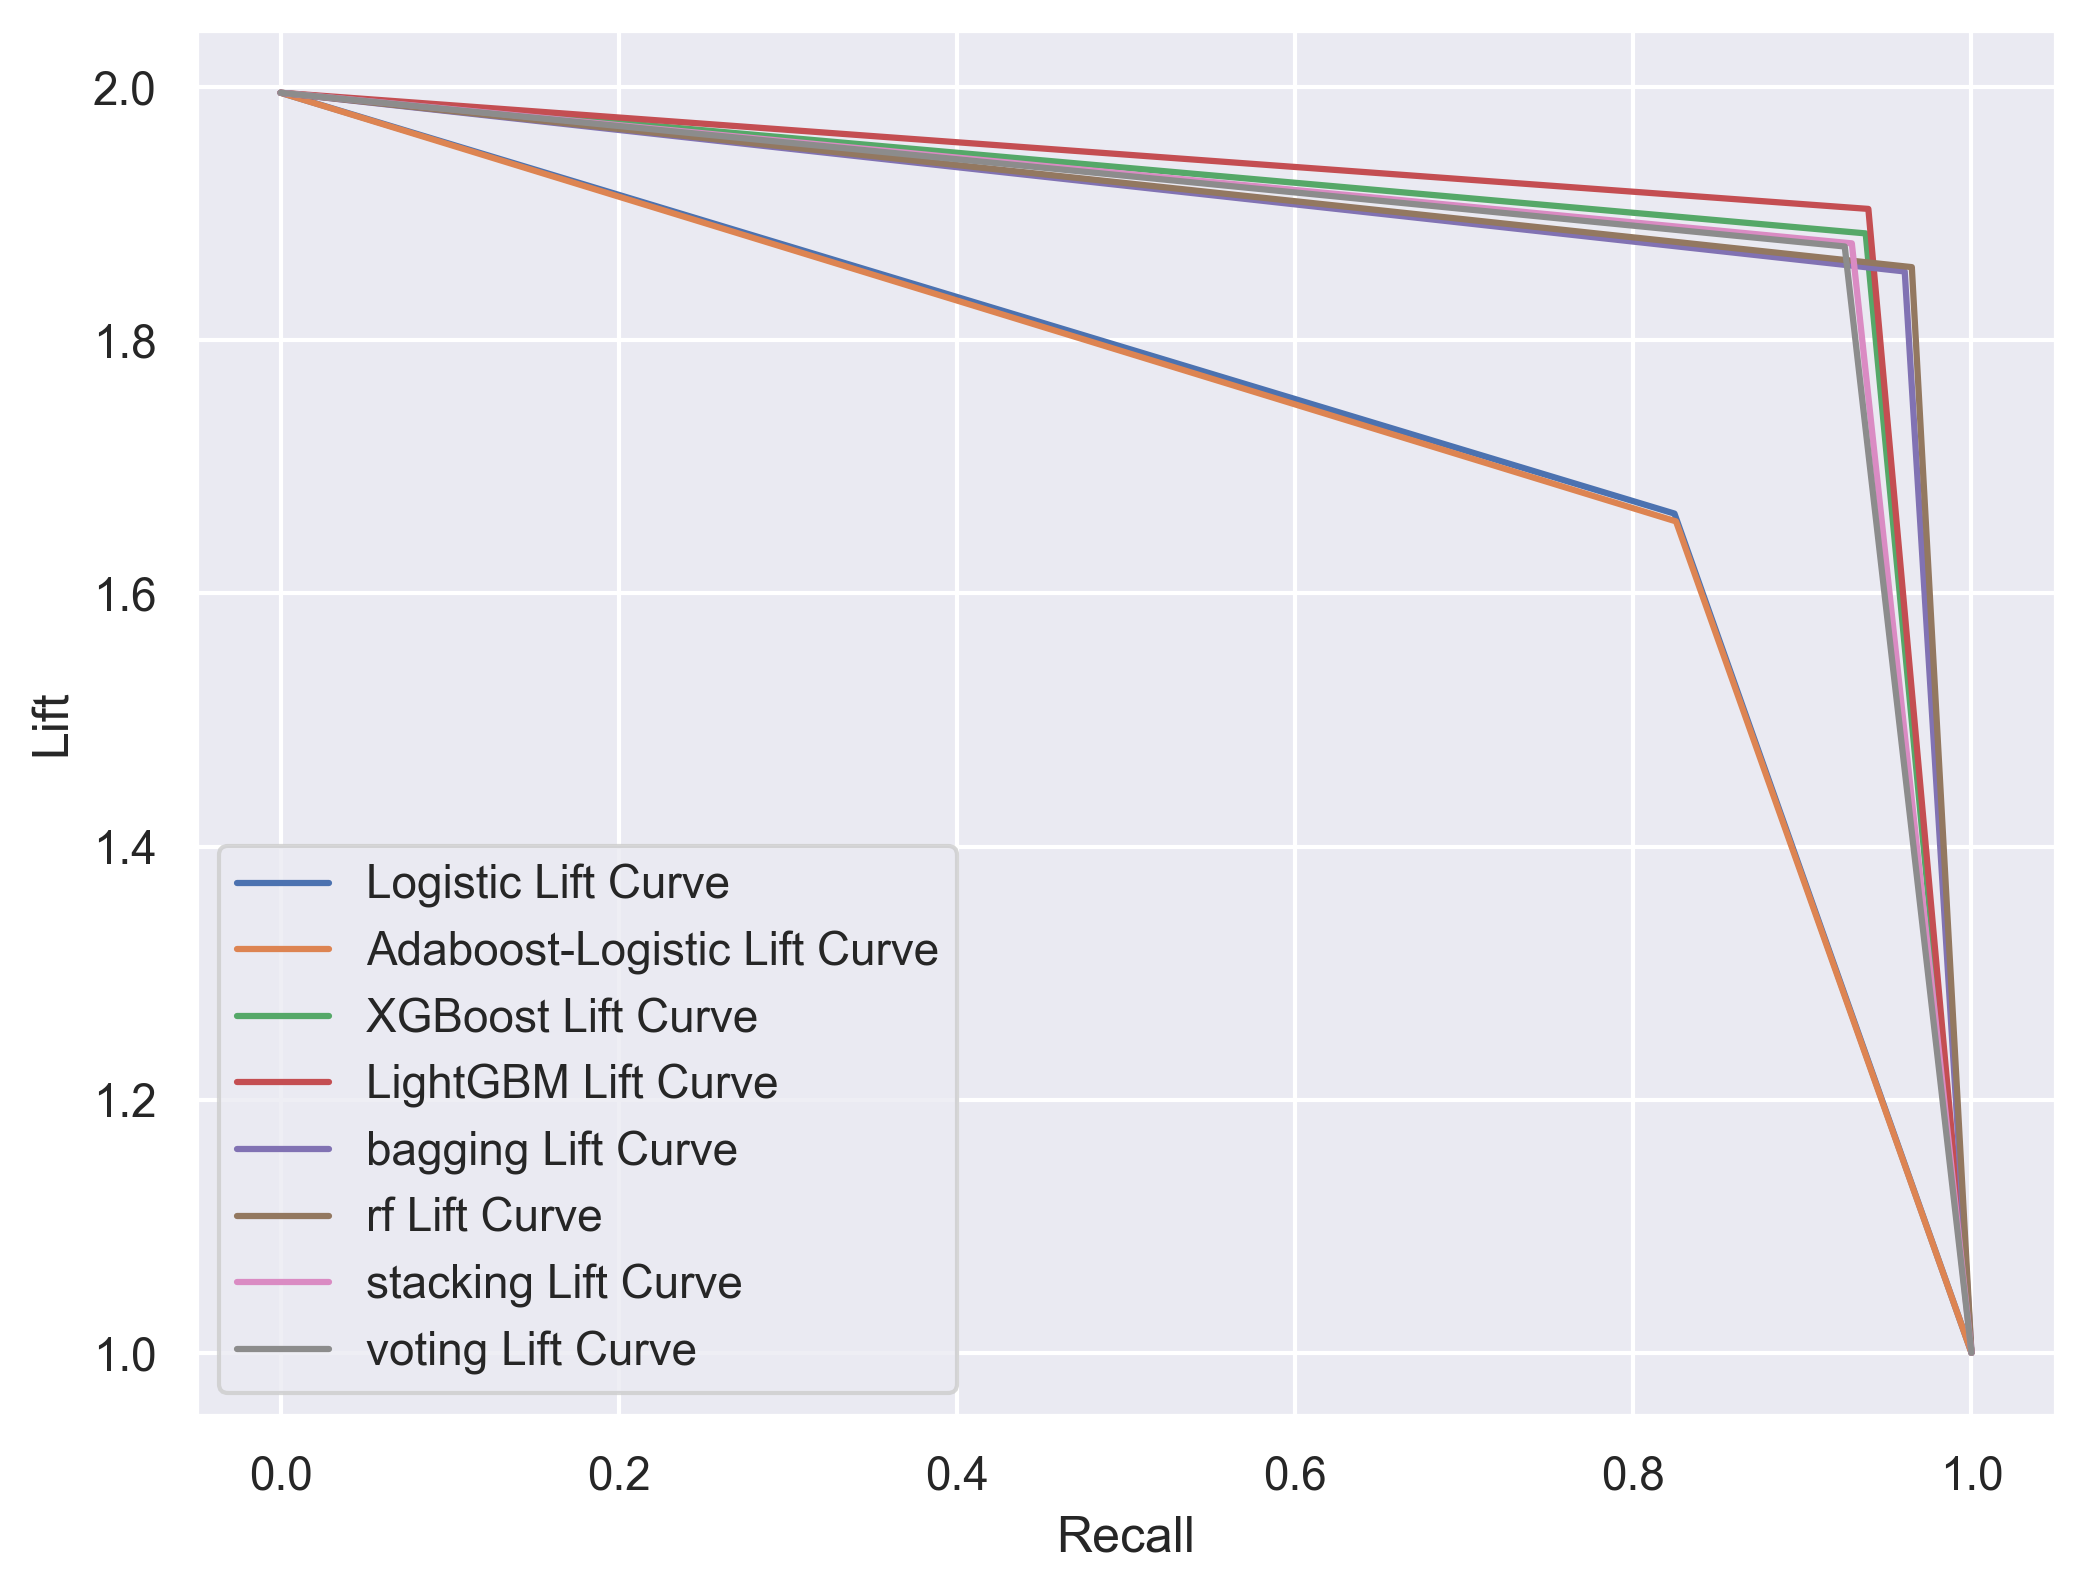

In [33]:
# lift曲线
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(recall_Logistic, lift_Logistic, label='Logistic Lift Curve')
plt.plot(recall_adLogistic, lift_adLogistic, label='Adaboost-Logistic Lift Curve')
plt.plot(recall_xgb, lift_xgb, label='XGBoost Lift Curve')
plt.plot(recall_lgb, lift_lgb, label='LightGBM Lift Curve')
plt.plot(recall_bag, lift_bag, label='bagging Lift Curve')
plt.plot(recall_rf, lift_rf, label='rf Lift Curve')
plt.plot(recall_stacking, lift_stacking, label='stacking Lift Curve')
plt.plot(recall_voting, lift_voting, label='voting Lift Curve')
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.legend()
plt.savefig(fname="各模型Lift曲线对比.png")

__结果表明：__ Ensemble Learning 相比Logistic和Adaboost-Logistic有显著提升，其中LightGBM、Random Forest相对好一点